#  The Deterministic Cake Eating Problem - Endogenous Grid Method Solution
### by [Jason DeBacker](http://jasondebacker.com), November 2019
This Jupyter notebook illustrates how to solve the deterministic cake eating problem using Carroll's (2006) endogenous grid method (EGM).

## The Problem:

$$V(w)=\max_{c} u(c)+\beta V(w'), \forall w\in[0,\bar{w}]$$

The necessary condition (after applying the envelope theorem) is given by the Euler equation:

$$ u'(c) = \beta u'(c') $$

The unknowns in this system are functions: The value function, $V(w)$, and the policy function, $c = \phi(w)$ (or, equivalently, $w' = p(w)$).

## The Solution:

We'll solve this problem using policy function iteration with the endogenous grid method.  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true policy function, $\phi(w)$, but we'll do some without the use of a minimizer or root-finder.  Another significant difference between EGM and standard PFI is that we'll choose a grid of $w'$ (and not $w$).  

The computational algorithm for EGM is as follows:

1. Create a discrete grid of the state variable, $w'$
2. Make an initial guess at the policy function, $\phi_{0}(w)$
    * This will a function that returns a consumption value for any $w$
3. Solve for $c$ for each point on the grid of $w'$ using the Euler equation:
$$ c = u^{'-1}\left(\beta u'(\phi_{0}(w'))\right)$$
4. Find the grid of $w$:
    $$w = w' + c$$
5. Using the grid for $w$, update the guess at the policy function: $\phi_{1}(w) = K\phi(w) = c $ (this is the $c$ solved for in step 3).
5. Repeat this process:
$$\phi_{i+1} \ (w) = K\phi(w) = c$$
6. Stop when, $|\phi_{i+1} \ (w)-\phi_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import interpolate

# to print plots inline
%matplotlib inline

## Step 1: Set parameters and create grid for state space

Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function

In [2]:
beta = 0.95
sigma = 1.0
R = 1

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_w      = scalar, lower bound of cake grid
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_w = 0.4 
ub_w = 2.0 
size_w = 200  # Number of grid points
w_grid = np.linspace(lb_w, ub_w, size_w)

## Step 2: Create functions to use in solution

In [3]:
def utility_c(C, sigma):
    if sigma == 1:
        U = np.log(C)
    else:
        U = (C ** (1 - sigma)) / (1 - sigma)
    
    return U


def u_prime(C, sigma):
    try:
        # replace 0 and negative consumption with a tiny value
        # to impose non-negativity on cons
        C[C<=0] = 1e-10 
    except TypeError:
        if C <= 0:
            C = 1e-10
    MU = C ** - sigma
    
    return MU


def u_prime_inv(C, sigma):
    try:
        # replace 0 and negative consumption with a tiny value
        # to impose non-negativity on cons
        C[C<=0] = 1e-10 
    except TypeError:
        if C <= 0:
            C = 1e-10
    MU = C ** (- 1 / sigma)
    
    return MU
    

In [4]:
def coleman_egm(phi, w_prime_grid, params):
    '''
    The Coleman-Endogenous Grid Method operator, which takes an
    existing guess phi of the optimal consumption policy and computes and
    returns the updated function Kphi on the endogenous grid points.
    '''
    beta, sigma = params
    
    # == Initialize c == #
    c = np.empty_like(w_prime_grid)

    # == solve for updated consumption value == #
    for i, w_prime in enumerate(w_prime_grid):
        c[i] = u_prime_inv(beta * u_prime(phi(w_prime), sigma), sigma)
    
    # == Determine endogenous grid == #
    w_grid = w_prime_grid / R + c
    
    # == Update policy function == #
    Kphi = interpolate.interp1d(w_grid, c, kind='linear', fill_value='extrapolate')
    return Kphi

## Step 3: Policy Function Iteration with EGM

In [6]:
'''
------------------------------------------------------------------------
Policy Function Iteration with Endogenous Grid Method
------------------------------------------------------------------------
PFtol     = scalar, tolerance required for policy function to converge
PFdist    = scalar, distance between last two policy functions
PFmaxiter = integer, maximum number of iterations for policy function
phi       = function, policy function for choice of consumption at each iteration
PFstore   = matrix, stores phi at each iteration 
PFiter    = integer, current iteration number
PF_params = tuple, contains parameters to pass into Coleman operator: beta, sigma
new_phi   = vector, updated policy function after applying Coleman operator 
------------------------------------------------------------------------
'''
PFtol = 1e-8 
PFdist = 7.0 
PFmaxiter = 500 
phi = lambda x:  x # initial guess at policy function is to eat all cake
PFstore = np.zeros((size_w, PFmaxiter)) #initialize PFstore array
PFiter = 1 
PF_params = (beta, sigma)
while PFdist > PFtol and PFiter < PFmaxiter:
    PFstore[:, PFiter] = phi(w_grid)
    new_phi = coleman_egm(phi, w_grid, PF_params)
    PFdist = (np.absolute(phi(w_grid) - new_phi(w_grid))).max()
    phi = new_phi
    PFiter += 1
    print('Iteration ', PFiter, ' distance = ', PFdist)

if PFiter < PFmaxiter:
    print('Policy function converged after this many iterations:', PFiter)
else:
    print('Policy function did not converge')   

Iteration  2  distance =  0.9743589743589745
Iteration  3  distance =  0.3245016741949255
Iteration  4  distance =  0.16203762968997615
Iteration  5  distance =  0.09705232549890097
Iteration  6  distance =  0.06456000857509103
Iteration  7  distance =  0.045993320368892865
Iteration  8  distance =  0.03438950085411352
Iteration  9  distance =  0.026653989424644364
Iteration  10  distance =  0.02123950516538356
Iteration  11  distance =  0.01730207604366693
Iteration  12  distance =  0.014349384407746107
Iteration  13  distance =  0.012078464911237013
Iteration  14  distance =  0.010294553477433466
Iteration  15  distance =  0.008867806749025903
Iteration  16  distance =  0.007708956780645204
Iteration  17  distance =  0.006754990271824884
Iteration  18  distance =  0.005960396989169253
Iteration  19  distance =  0.005291642456028645
Iteration  20  distance =  0.00472357520273442
Iteration  21  distance =  0.004237031601985658
Iteration  22  distance =  0.0038172028039138717
Iteration 

Iteration  172  distance =  7.75957448989617e-07
Iteration  173  distance =  7.371484242041371e-07
Iteration  174  distance =  7.0028093832053e-07
Iteration  175  distance =  6.652578081467464e-07
Iteration  176  distance =  6.319867204146457e-07
Iteration  177  distance =  6.003799862541737e-07
Iteration  178  distance =  5.703543104057518e-07
Iteration  179  distance =  5.41830569300572e-07
Iteration  180  distance =  5.147336028799021e-07
Iteration  181  distance =  4.889920150602522e-07
Iteration  182  distance =  4.645379851758724e-07
Iteration  183  distance =  4.4130708873324487e-07
Iteration  184  distance =  4.1923812675592753e-07
Iteration  185  distance =  3.982729648160932e-07
Iteration  186  distance =  3.783563783665844e-07
Iteration  187  distance =  3.594359077319087e-07
Iteration  188  distance =  3.414617191915825e-07
Iteration  189  distance =  3.2438647343258076e-07
Iteration  190  distance =  3.081652005937352e-07
Iteration  191  distance =  2.927551814302376e-07
I

## Step 4: Extract decision rules from solution

In [7]:
'''
------------------------------------------------------------------------
Find savings policy function and value function   
------------------------------------------------------------------------
optC  = vector, the optimal choice of c for each c
optW  = vector, the optimal choice of w' for each w
VF    = vector, the "true" value function
------------------------------------------------------------------------
'''
optC = phi(w_grid) # optimal consumption
optW = R * (w_grid - optC) # solution to the savings policy function from transition equation

## Visualize output

<Figure size 432x288 with 0 Axes>

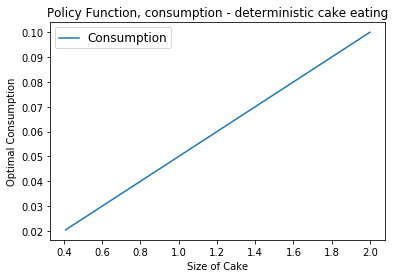

In [8]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

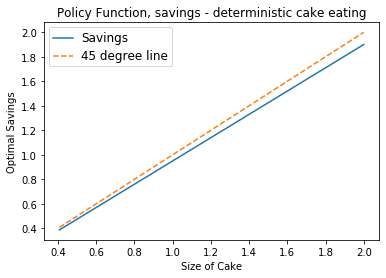

In [9]:
#Plot cake to leave rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optW[1:], label='Savings')
ax.plot(w_grid[1:], w_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Savings')
plt.title('Policy Function, savings - deterministic cake eating')
plt.show()

## Finding approximation errors

It's a little complicated (we need to do the guess and verify method), but we can show that with $\sigma = 1.0$ (i.e., $u(c) = log(c)$), then the policy function is $w' = \beta w$.  Knowing this, we can find the approximation error from our solution method (VFI over a discrete grid).  This errors are found as:

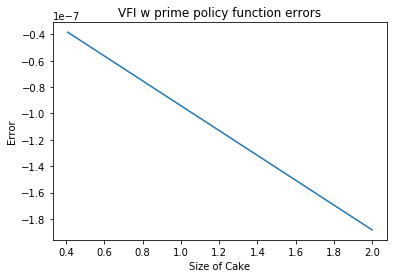

In [10]:
Wprime_errors = optW - beta * w_grid

# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], Wprime_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI w prime policy function errors')
plt.show()

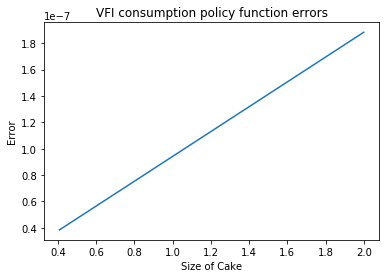

In [11]:
C_errors = optC - (1 - beta) * w_grid
# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], C_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI consumption policy function errors')
plt.show()